In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('/content/ai4i2020.csv')
print(df.head())
print(df.info())
print(df['Machine failure'].value_counts())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('ai4i2020.csv')

# Preprocessing
# Drop unnecessary columns
df = df.drop(['UDI', 'Product ID'], axis=1)

# Encode 'Type' column
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

# Define X and y
X = df.drop(['Machine failure'], axis=1)
y = df['Machine failure']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model - Gradient Boosting (alternative to XGBoost)
# To avoid overfitting/underfitting, we tune hyperparameters
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0] # Subsampling helps reduce overfitting
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

Best Params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.9985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       0.99      0.97      0.98        68

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 0.9850353184752163


In [ ]:
# Check relationship between Machine failure and failure modes
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df['sum_failures'] = df[failure_modes].sum(axis=1)
print(pd.crosstab(df['Machine failure'], df['sum_failures']))

# Try training without failure modes
# X_sensor = df.drop(['Machine failure', 'UDI', 'Product ID', 'sum_failures'] + failure_modes, axis=1) # This line caused the error
# Re-encode Type if needed (it was encoded in place in previous cell, but safe to re-do or assume it's encoded)
# actually df from previous cell is in memory.
# Let's just use the column names to drop from the current df
X_sensor = df.drop(['Machine failure', 'sum_failures'] + failure_modes, axis=1) # df already has UDI/Product ID dropped

y_sensor = df['Machine failure']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_sensor, y_sensor, test_size=0.2, random_state=42, stratify=y_sensor)

gb_s = GradientBoostingClassifier(random_state=42)
grid_search_s = GridSearchCV(estimator=gb_s, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_s.fit(X_train_s, y_train_s)

best_model_s = grid_search_s.best_estimator_
y_pred_s = best_model_s.predict(X_test_s)

print("\n--- Without Failure Mode Columns ---")
print("Best Params:", grid_search_s.best_params_)
print("Accuracy:", accuracy_score(y_test_s, y_pred_s))
print(classification_report(y_test_s, y_pred_s))
print("ROC AUC:", roc_auc_score(y_test_s, y_pred_s))

sum_failures        0    1   2  3
Machine failure                  
0                9643   18   0  0
1                   9  306  23  1

--- Without Failure Mode Columns ---
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.9855
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.85      0.69      0.76        68

    accuracy                           0.99      2000
   macro avg       0.92      0.84      0.88      2000
weighted avg       0.98      0.99      0.98      2000

ROC AUC: 0.8435178419193764


In [ ]:
# Reload to be clean
df = pd.read_csv('ai4i2020.csv')

# Preprocessing
# Drop ID columns
df = df.drop(['UDI', 'Product ID'], axis=1)

# Encode Type
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

# Define Failure Modes columns to drop for the feature set
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# X should only contain sensor data + Type
X = df.drop(['Machine failure'] + failure_modes, axis=1)
y = df['Machine failure']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Grid Search with GradientBoosting
gb = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.9855
ROC AUC: 0.966729082937523
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.84      0.71      0.77        68

    accuracy                           0.99      2000
   macro avg       0.92      0.85      0.88      2000
weighted avg       0.98      0.99      0.98      2000



In [ ]:
df = pd.read_csv('ai4i2020.csv')
df = df.drop(['UDI', 'Product ID'], axis=1)
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
X = df.drop(['Machine failure'] + failure_modes, axis=1)
y = df['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

gb = GradientBoostingClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))
print(classification_report(y_test, y_pred))

Best Params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.987
ROC AUC: 0.9614313116550969
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.74      0.79        68

    accuracy                           0.99      2000
   macro avg       0.93      0.87      0.89      2000
weighted avg       0.99      0.99      0.99      2000



In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and Preprocess
df = pd.read_csv('ai4i2020.csv')
df = df.drop(['UDI', 'Product ID'], axis=1)
df['Type'] = LabelEncoder().fit_transform(df['Type'])

# Remove target leakage columns (failure modes) for a generalized model
X = df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = df['Machine failure']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Best Model
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=42,
                           subsample=0.8)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load and Preprocess
df = pd.read_csv('ai4i2020.csv')
df = df.drop(['UDI', 'Product ID'], axis=1)
df['Type'] = LabelEncoder().fit_transform(df['Type'])

# Remove leakage columns
X = df.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
y = df['Machine failure']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Model
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
model.fit(X_train, y_train)

features = X.columns

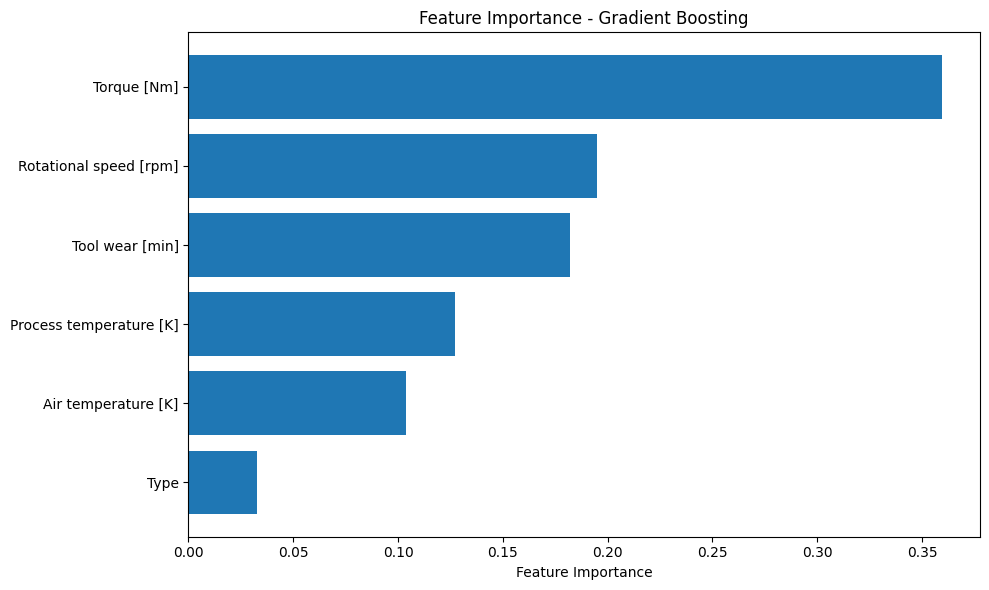

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()
plt.show()

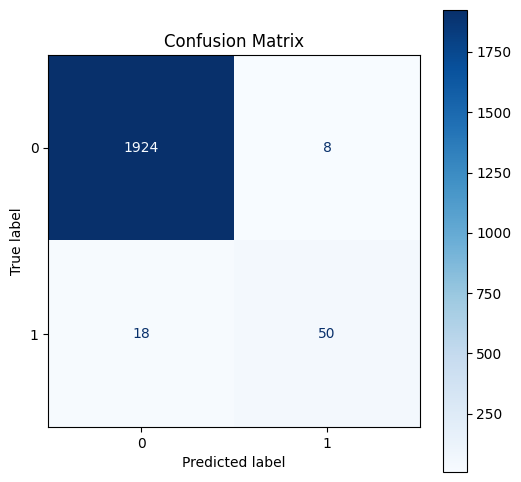

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.show()

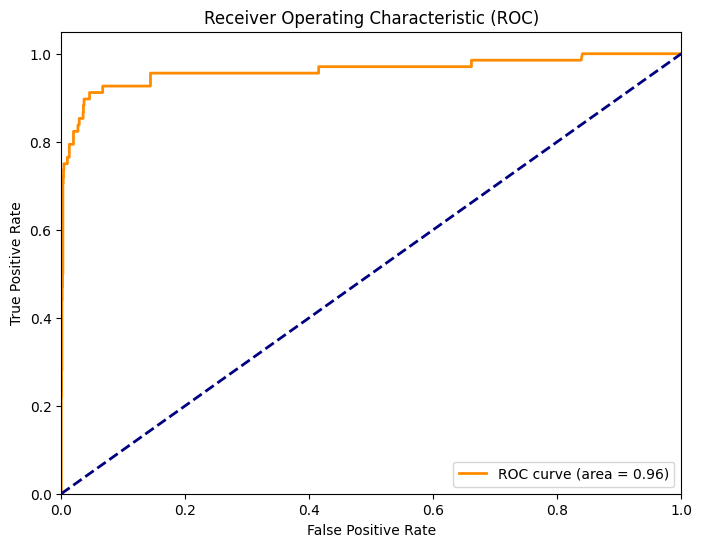

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

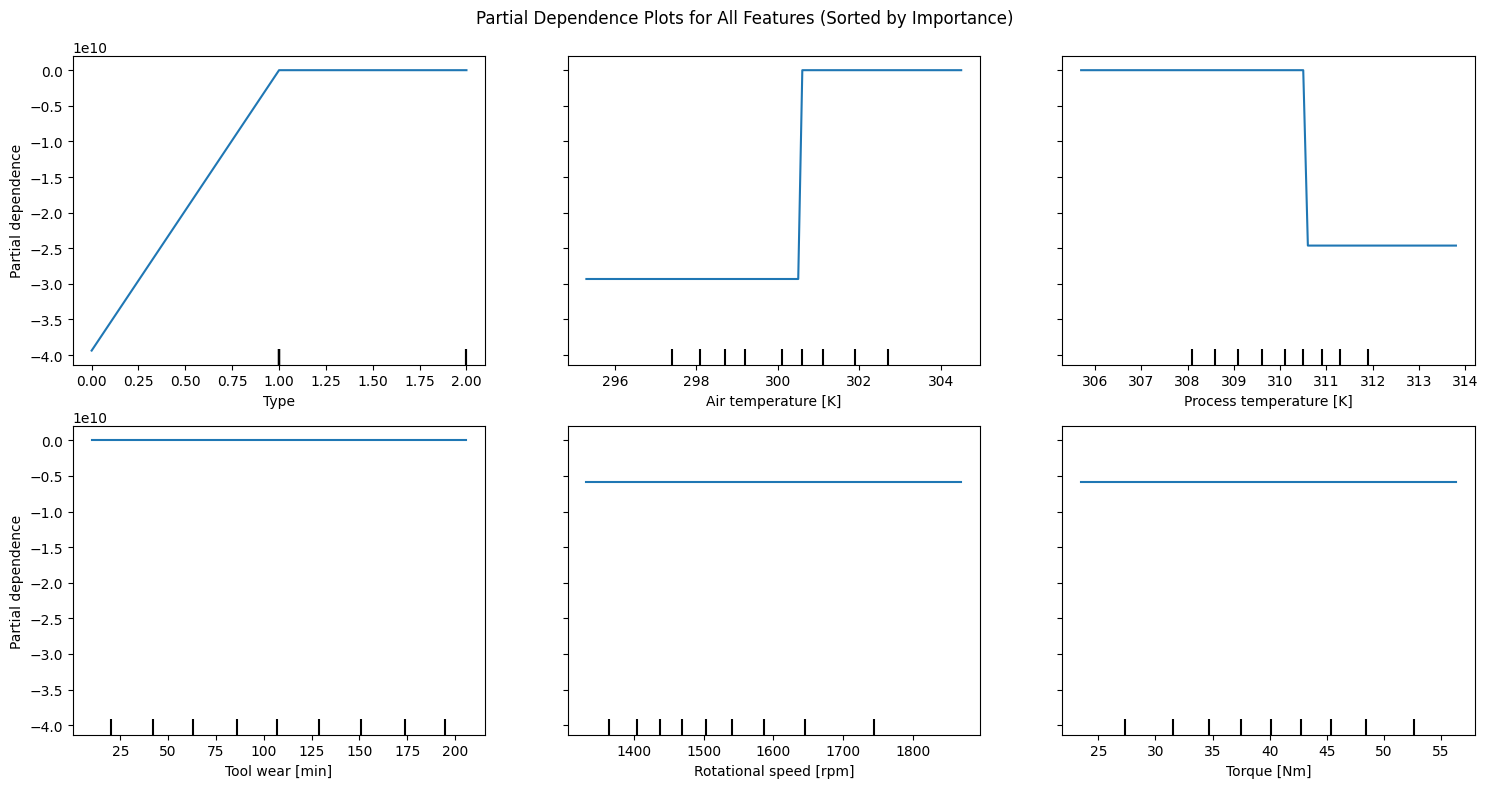

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.feature_importances_
sorted_idx = feature_importance.argsort()

# Plot all features, sorted by importance
# Adjust figsize for 2 rows x 3 columns (6 features total)
fig, ax = plt.subplots(figsize=(15, 8))
PartialDependenceDisplay.from_estimator(model, X_train, features[sorted_idx], ax=ax, n_cols=3)
plt.suptitle('Partial Dependence Plots for All Features (Sorted by Importance)')
plt.tight_layout()
plt.show()